# Project Setu: Identity Health Score (IHS) Simulation
## UIDAI Data Hackathon 2026 - Official Submission

### 1. Introduction

This notebook, **Notebook 03**, introduces the **Identity Health Score (IHS)**. The IHS is a citizen-centric metric designed to encourage proactive identity maintenance.

#### What is the Identity Health Score?
- A score ranging from **0 to 900**.
- Reflects the "freshness" of a resident's Aadhaar biometrics and demographics.
- **Non-punitive**: A low score does not lead to denial of service; it serves as a nudge for maintenance.
- **Private**: Intended to be visible only to the resident via the mAadhaar app or portal.

#### Objectives
- Demonstrate the logic for calculating the IHS using aggregated data.
- Simulate score distributions to understand population-level identity hygiene.
- Illustrate how the score can be used for proactive service delivery.

#### Data Privacy & Ethics
> **MANDATORY DISCLOSURE:**
> - This simulation uses **aggregated population data** to model score distributions.
> - No individual Aadhaar data or real scores are used.
> - The IHS is an **informational tool**, not a surveillance mechanism.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 2. IHS Calculation Logic

The score is calculated based on three primary factors:
1. **Biometric Freshness (60%)**: Time since last MBU (critical for age 5 and 15).
2. **Demographic Accuracy (30%)**: Recent updates to address, phone, or email.
3. **Authentication Success Rate (10%)**: Historical success of biometric matches.

For this simulation, we use the aggregated update activity as a proxy for "Identity Hygiene" in a given pincode.

In [2]:
def calculate_pincode_ihs(mbu_rate, demo_rate):
    """
    Simulates an average IHS for a pincode based on update rates.
    Higher update rates relative to population suggest better identity hygiene.
    """
    # Base score
    base = 600
    
    # Bonus for biometric updates (MBU compliance)
    bio_bonus = np.clip(mbu_rate * 200, 0, 200)
    
    # Bonus for demographic updates
    demo_bonus = np.clip(demo_rate * 100, 0, 100)
    
    return base + bio_bonus + demo_bonus

print("IHS Logic Defined.")

IHS Logic Defined.


### 3. Load Aggregated Data

We use the enrolment data as a proxy for the "eligible population" to calculate update rates.

In [3]:
def load_and_concat(pattern):
    files = glob.glob(pattern)
    df_list = [pd.read_csv(f) for f in files]
    return pd.concat(df_list, ignore_index=True)

base_path = '/home/ubuntu/project_setu_data/data/'

df_bio = load_and_concat(os.path.join(base_path, 'biometric/*.csv'))
df_demo = load_and_concat(os.path.join(base_path, 'demographic/*.csv'))
df_enrol = load_and_concat(os.path.join(base_path, 'enrollment/*.csv'))

# Aggregate by pincode
pincode_stats = df_bio.groupby('pincode')['bio_age_5_17'].sum().reset_index()
pincode_demo = df_demo.groupby('pincode')['demo_age_5_17'].sum().reset_index()
pincode_pop = df_enrol.groupby('pincode')['age_5_17'].sum().reset_index()

# Merge
df_ihs = pd.merge(pincode_stats, pincode_demo, on='pincode')
df_ihs = pd.merge(df_ihs, pincode_pop, on='pincode')

# Calculate rates (Updates per 1000 enrolled children)
df_ihs['mbu_rate'] = (df_ihs['bio_age_5_17'] / df_ihs['age_5_17']).replace([np.inf, -np.inf], 0).fillna(0)
df_ihs['demo_rate'] = (df_ihs['demo_age_5_17'] / df_ihs['age_5_17']).replace([np.inf, -np.inf], 0).fillna(0)

# Apply IHS Logic
df_ihs['avg_pincode_ihs'] = df_ihs.apply(lambda x: calculate_pincode_ihs(x['mbu_rate'], x['demo_rate']), axis=1)

df_ihs.head()

,pincode,bio_age_5_17,demo_age_5_17,age_5_17,mbu_rate,demo_rate,avg_pincode_ihs
0,110001,1321,331,39,33.871795,8.487179,900.0
1,110002,2992,357,79,37.873418,4.518987,900.0
2,110003,2744,245,232,11.827586,1.056034,900.0
3,110004,87,6,1,87.000000,6.000000,900.0
4,110005,4634,834,202,22.940594,4.128713,900.0


### 4. Visualizing IHS Distribution

We visualize the distribution of the Identity Health Score across all pincodes to identify areas with low "Identity Hygiene."

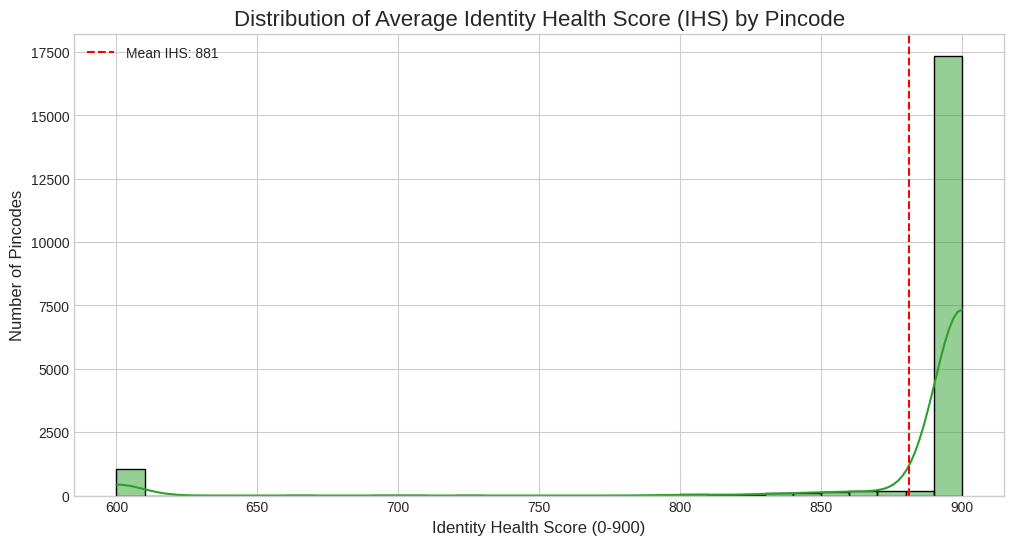

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(df_ihs['avg_pincode_ihs'], bins=30, kde=True, color='#2ca02c')
plt.axvline(df_ihs['avg_pincode_ihs'].mean(), color='red', linestyle='--', label=f'Mean IHS: {df_ihs["avg_pincode_ihs"].mean():.0f}')

plt.title('Distribution of Average Identity Health Score (IHS) by Pincode', fontsize=16)
plt.xlabel('Identity Health Score (0-900)', fontsize=12)
plt.ylabel('Number of Pincodes', fontsize=12)
plt.legend()
plt.show()

### 5. IHS-Driven Nudge Strategy

We categorize pincodes based on their average IHS to determine the appropriate intervention strategy.

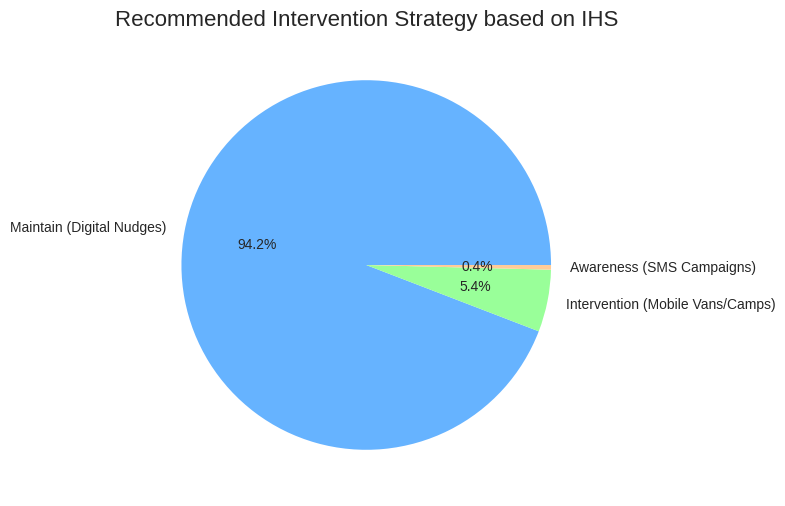

In [5]:
def get_strategy(score):
    if score > 800: return 'Maintain (Digital Nudges)'
    elif score > 700: return 'Awareness (SMS Campaigns)'
    else: return 'Intervention (Mobile Vans/Camps)'

df_ihs['strategy'] = df_ihs['avg_pincode_ihs'].apply(get_strategy)

strategy_counts = df_ihs['strategy'].value_counts()

plt.figure(figsize=(10, 6))
strategy_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Recommended Intervention Strategy based on IHS', fontsize=16)
plt.ylabel('')
plt.show()

### 6. Interpretation & Ethical Design

#### Why the IHS is Effective
- **Gamification of Compliance**: By providing a score, residents are more likely to view identity maintenance as a positive habit rather than a bureaucratic hurdle.
- **Early Warning**: A declining score can trigger a nudge *before* a resident faces an authentication failure at a bank or hospital.

#### Ethical Safeguards
1. **No Denial of Service**: The IHS must never be used to restrict access to government benefits or services.
2. **Privacy by Design**: The score calculation logic should be transparent, but the individual score remains private to the resident.
3. **Equity**: Lower scores in rural or marginalized areas should trigger **increased government support** (e.g., more mobile vans) rather than penalties.

---
*Project Setu: Empowering residents through proactive identity health.*